## Classificador para apoio à decisão de aprovação de crédito 

### O projeto busca identificar, dentre clientes que solicitam um produto de crédito (como um cartão de crédito ou um empréstimo pessoal, por exemplo), aqueles que apresentem alto risco de não conseguirem honrar o pagamento, tornando-se inadimplentes.

### Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

### Importando dados

In [2]:
dados = pd.read_csv("CreditoDados\conjunto_de_treinamento.csv")
dados_teste = pd.read_csv("CreditoDados\conjunto_de_teste.csv")
exemplo = pd.read_csv("CreditoDados\exemplo_arquivo_respostas.csv")

### Limpando os dados


#### Primeiramente foram retiradas as colunas indesejadas


In [3]:
dados.set_index('id_solicitante', inplace=True)
dados = dados.drop(['grau_instrucao',   # Falha na extração
                    'possui_telefone_celular',  # Falha na extração
                    'qtde_contas_bancarias_especiais', # Idêntico a coluna 'qntde_contas_bancarias'
                    'tipo_endereco',  # Vasta maioria com o atributo 1
                    'codigo_area_telefone_residencial', # One hot encoding ficaria muito grande
                    'estado_onde_trabalha', # Muitos valores vazios
                    'codigo_area_telefone_trabalho', # Muitos valores vazios
                    'meses_no_trabalho', # Vasta maioria com valor 0
                    'profissao', # One Hot encoding muito grande
                    'profissao_companheiro', # One Hot encoding muito grande
                    'local_onde_reside', # One Hot encoding muito grande
                    'local_onde_trabalha'],axis=1) # One Hot encoding muito grande



dados_teste.set_index('id_solicitante', inplace=True)
dados_teste = dados_teste.drop(['grau_instrucao',   # Falha na extração
                    'possui_telefone_celular',  # Falha na extração
                    'qtde_contas_bancarias_especiais', # Idêntico a coluna 'qntde_contas_bancarias'
                    'tipo_endereco',  # Vasta maioria com o atributo 1
                    'codigo_area_telefone_residencial', # One hot encoding ficaria muito grande
                    'estado_onde_trabalha', # Muitos valores vazios
                    'codigo_area_telefone_trabalho', # Muitos valores vazios
                    'meses_no_trabalho', # Vasta maioria com valor 0
                    'profissao', # One Hot encoding muito grande
                    'profissao_companheiro', # One Hot encoding muito grande
                    'local_onde_reside', # One Hot encoding muito grande
                    'local_onde_trabalha' # One Hot encoding muito grande
                    ],axis=1) 

#### Depois foi feita uma análise para avaliar as colunas que deveriam ser modificadas

In [4]:
for coluna in dados.columns:
    print('Valores de ' + coluna)
    print(dados[coluna].value_counts())

Valores de produto_solicitado
1    17023
2     2435
7      542
Name: produto_solicitado, dtype: int64
Valores de dia_vencimento
10    7847
15    3557
25    3089
5     2825
20    1952
1      730
Name: dia_vencimento, dtype: int64
Valores de forma_envio_solicitacao
internet      11264
presencial     7855
correio         881
Name: forma_envio_solicitacao, dtype: int64
Valores de sexo
F    12246
M     7722
N       25
         7
Name: sexo, dtype: int64
Valores de idade
40     555
39     534
36     526
32     518
37     513
      ... 
94       2
96       2
7        1
100      1
97       1
Name: idade, Length: 84, dtype: int64
Valores de estado_civil
2    10088
1     6519
4     1573
6      763
5      522
3      234
7      220
0       81
Name: estado_civil, dtype: int64
Valores de qtde_dependentes
0     13350
1      2814
2      2189
3      1029
4       352
5       149
6        57
7        22
8        14
9         9
10        7
11        4
13        2
53        1
14        1
Name: qtde_depende

#### E foi constatado que algumas colunas continham valores nulos ou possíveis erros de digitação que precisavam ser corrigidos

In [5]:
dados.loc[dados['sexo'] == ' ','sexo'] = 'N' # Valores vazios são tratados como 'N'
dados.loc[dados['idade'] < 17,'idade'] = 17 # Observações com menores de 17 anos foram consideradas erros de extração
dados.loc[dados['qtde_dependentes'] > 14,'qtde_dependentes'] = 14 # Observações com maiores de 14 depedentes foram consideradas erros de extração
dados.loc[dados['estado_onde_nasceu'] == ' ','estado_onde_nasceu'] = 'N'# Valores vazios são tratados como 'N'
dados['grau_instrucao_companheiro'] = dados['grau_instrucao_companheiro'].fillna(0) # Valores nulos foram preenchidos com 0 pois era o valor predominante nas observações
dados['ocupacao'] = dados['ocupacao'].fillna(2.0) # Valores nulos foram preenchidos com 2.0 pois era o valor predominante nas observações 
dados['meses_na_residencia'] = dados['meses_na_residencia'].fillna(10.0) # Valores nulos foram preenchidos com 10.0 pois era o valor predominante nas observações  

dados_teste.loc[dados_teste['sexo'] == ' ','sexo'] = 'N' # Valores vazios são tratados como 'N'
dados_teste.loc[dados_teste['idade'] < 17,'idade'] = 17 # Observações com menores de 17 anos foram consideradas erros de extração
dados_teste.loc[dados_teste['qtde_dependentes'] > 14,'qtde_dependentes'] = 14 # Observações com maiores de 14 depedentes foram consideradas erros de extração
dados_teste.loc[dados_teste['estado_onde_nasceu'] == ' ','estado_onde_nasceu'] = 'N' # Valores vazios são tratados como 'N'
dados_teste['grau_instrucao_companheiro'] = dados_teste['grau_instrucao_companheiro'].fillna(0) # Valores nulos foram preenchidos com 0 pois era o valor predominante nas observações
dados_teste['ocupacao'] = dados_teste['ocupacao'].fillna(2.0) # Valores nulos foram preenchidos com 2.0 pois era o valor predominante nas observações  
dados_teste['meses_na_residencia'] = dados_teste['meses_na_residencia'].fillna(10.0)  # Valores nulos foram preenchidos com 10.0 pois era o valor predominante nas observações   

#### Sabendo que alguns algoritmos necessitam que todos os dados sejam numéricos e não categóricos, foi utilizada a técnina de "One-Hot Encoding" para fazer esta conversão

In [6]:
dados = pd.get_dummies(dados,columns=['produto_solicitado',
                                      'forma_envio_solicitacao',
                                      'sexo',
                                      'estado_civil',
                                      'nacionalidade',
                                      'tipo_residencia',
                                      'ocupacao'])

dados_teste = pd.get_dummies(dados_teste,columns=['produto_solicitado',
                                      'forma_envio_solicitacao',
                                      'sexo',
                                      'estado_civil',
                                      'nacionalidade',
                                      'tipo_residencia',
                                      'ocupacao'])

#### Enquanto para as colunas com apenas 2 atributos foi utilzada a binarização, atribuindo os valores 0 ou 1

In [7]:
binalizer = LabelBinarizer()

for coluna in ['possui_telefone_residencial',
               'vinculo_formal_com_empresa',
               'possui_telefone_trabalho']:
    dados[coluna] = binalizer.fit_transform(dados[coluna])
    dados_teste[coluna] = binalizer.fit_transform(dados_teste[coluna])
    

### Análise para escolher colunas

#### Foram então verificadas as médias de cada coluna para os inadimplentes e não inadimplentes, para decidir quais atributos seriam selecionados para o treinamento do modelo, sabendo que atributos com maiores diferenças tendem a ter um bom indicativo de que ajudarão no treinamento do modelo

In [8]:
for coluna in dados.columns:
    if coluna != 'inadimplente' and dados[coluna].dtype != 'O':
        print("Diferença nas médias de " + coluna)
        print(abs(dados.groupby('inadimplente').mean()[coluna][0] - dados.groupby('inadimplente').mean()[coluna][1])*(100/dados.groupby('inadimplente').mean()[coluna][1]))
        print('\n')

Diferença nas médias de dia_vencimento
7.920726985843054


Diferença nas médias de idade
8.88345276905095


Diferença nas médias de qtde_dependentes
6.9020633536762555


Diferença nas médias de possui_telefone_residencial
7.768949426157143


Diferença nas médias de meses_na_residencia
7.149482312338227


Diferença nas médias de possui_email
0.5772367925712055


Diferença nas médias de renda_mensal_regular
2.2205350326969064


Diferença nas médias de renda_extra
34.38731767341488


Diferença nas médias de possui_cartao_visa
0.7373271889400876


Diferença nas médias de possui_cartao_mastercard
13.131313131313133


Diferença nas médias de possui_cartao_diners
11.764705882352933


Diferença nas médias de possui_cartao_amex
4.999999999999991


Diferença nas médias de possui_outros_cartoes
14.285714285714281


Diferença nas médias de qtde_contas_bancarias
3.6966567001902693


Diferença nas médias de valor_patrimonio_pessoal
5.0071223659598045


Diferença nas médias de possui_carro
3.50623007

#### Colunas com diferenças nas médias menores que 2 foram então retiradas da tabela

In [9]:
atributos_selecionados = [ 'dia_vencimento',
                           'idade',
                           'qtde_dependentes',
                          # 'estado_onde_nasceu',
                          # 'estado_onde_reside',
                           'possui_telefone_residencial',
                           'meses_na_residencia',
                          #     'possui_email',
                           'renda_mensal_regular',
                           'renda_extra',
                          # 'possui_cartao_visa',
                           'possui_cartao_mastercard',
                           'possui_cartao_diners',
                           'possui_cartao_amex',
                           'possui_outros_cartoes',
                           'qtde_contas_bancarias',
                           'valor_patrimonio_pessoal',
                           'possui_carro',
                          # 'vinculo_formal_com_empresa',
                           'possui_telefone_trabalho',
                           'grau_instrucao_companheiro',
                          # 'produto_solicitado_1',
                          # 'produto_solicitado_2',
                           'produto_solicitado_7',
                           'forma_envio_solicitacao_correio',
                          # 'forma_envio_solicitacao_internet',
                           'forma_envio_solicitacao_presencial',
                           'sexo_F',
                           'sexo_M',
                           'sexo_N',
                           'estado_civil_0',
                           'estado_civil_1',
                           'estado_civil_2',
                           'estado_civil_3',
                           'estado_civil_4',
                           'estado_civil_5',
                           'estado_civil_6',
                           'estado_civil_7',
                          # 'nacionalidade_0',
                          # 'nacionalidade_1',
                          # 'nacionalidade_2',
                           'tipo_residencia_0.0',
                           'tipo_residencia_1.0',
                           'tipo_residencia_2.0',
                           'tipo_residencia_3.0',
                           'tipo_residencia_4.0',
                           'tipo_residencia_5.0',
                           'ocupacao_0.0',
                           'ocupacao_1.0',
                           'ocupacao_2.0',
                           'ocupacao_3.0',
                           'ocupacao_4.0',
                           'ocupacao_5.0',
                           'inadimplente']

dados = dados[atributos_selecionados]
dados_teste = dados_teste[atributos_selecionados[0:-1]]


### Dividindo o dataset

#### Separamos então a coluna alvo dos atributos, e em seguida os conjuntos de treinameno e de teste

In [10]:
X = dados.iloc[:,dados.columns != 'inadimplente'].values
y = dados.iloc[:,dados.columns == 'inadimplente'].values.ravel()


X_train, X_test, y_train,y_test = train_test_split(X,y, train_size=15000, random_state = 42)

### Ajustando a escala

#### Para evitar que atributos tenham pesos maiores que outros, precisamos ajustar a escala dos conjuntos de dados

In [11]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
dados_teste = scaler.transform(dados_teste)

### Avaliando resultados dos modelos

#### Foi criada uma função para auxilar na visualização dos melhores parâmetros de um modelo escolhido, que neste caso foram o KNN e RandomForestClassifier

In [12]:
def resultados(grid):
    results = pd.DataFrame(grid.cv_results_)
    results.sort_values(by='rank_test_score', inplace=True)
    results = results[['params','mean_test_score','std_test_score']].head()
    
    return results

#### E utilizando a função GridSearchCV encontramos os melhores modelos para cada algoritmo

In [13]:
# RandomForest
parametersRF = {
    "max_depth":[2,8,14],
    "max_features": ['auto','sqrt','log2'],
    "n_estimators": [500],
    "min_samples_leaf":[2,10,18]
    }

gridRF = GridSearchCV(RandomForestClassifier(), parametersRF, cv=5, verbose=2, n_jobs = -1)
gridRF.fit(X, y)

resultadosRF = resultados(gridRF)
bestRF = gridRF.best_estimator_
bestRF.fit(X,y)
respostaRF = bestRF.predict(dados_teste)

# KNN
parametersKNN = {
    "p": [1,2],
    "n_neighbors": list(range(121,222,20)),
    'weights': ['distance','uniform'],
    'algorithm':['auto']
    }

gridknn = GridSearchCV(KNeighborsClassifier(), parametersKNN, cv=5, verbose=2, n_jobs =-1)
gridknn.fit(X,y)

resultadosknn = resultados(gridknn)
bestknn = gridknn.best_estimator_
bestknn.fit(X,y)
respostaknn = bestknn.predict(dados_teste)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [20]:
resultadosknn

,params,mean_test_score,std_test_score
20,"{'algorithm': 'auto', 'n_neighbors': 221, 'p':...",0.56275,0.006980
8,"{'algorithm': 'auto', 'n_neighbors': 161, 'p':...",0.56020,0.008276
16,"{'algorithm': 'auto', 'n_neighbors': 201, 'p':...",0.56005,0.007070
9,"{'algorithm': 'auto', 'n_neighbors': 161, 'p':...",0.55990,0.004268
12,"{'algorithm': 'auto', 'n_neighbors': 181, 'p':...",0.55960,0.007162


In [22]:
resultadosRF

,params,mean_test_score,std_test_score
19,"{'max_depth': 14, 'max_features': 'auto', 'min...",0.59015,0.003184
13,"{'max_depth': 8, 'max_features': 'sqrt', 'min_...",0.58935,0.003767
26,"{'max_depth': 14, 'max_features': 'log2', 'min...",0.58895,0.005439
20,"{'max_depth': 14, 'max_features': 'auto', 'min...",0.58890,0.003974
23,"{'max_depth': 14, 'max_features': 'sqrt', 'min...",0.58890,0.003597


#### Está claro que o RandomForest fornece resultados melhores, então este será o algoritmo escolhido


In [25]:
resposta_final = respostaRF

exemplo['inadimplente'] = respostaRF
exemplo.to_csv('resposta1.csv', index= False)

#### O que me gerou uma pontuação de 0.58640 no Kaggle

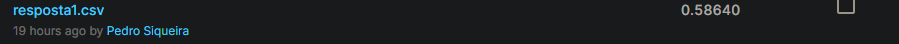